In [1]:
from new_stations import *
from time_series_model import *
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from scipy import signal
from scipy import stats








In [2]:
data, weather = load_data()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [3]:
data = feature_addition(data)

In [4]:
sf = model_city(data,1)

In [5]:
#cdf = current month df
#ndf = next month df
cdf, ndf = month_sep(sf, 2018, 4)

In [6]:
#proposed stations
ps = new_stn_coords(cdf, ndf)

In [7]:
ps

[155.0, 148.0, 163.0]

In [8]:
df1 = cdf

In [9]:
df2 = ndf

In [10]:
qtr = days_for_ts(sf, cdf,3)

/Users/michellehoang/galvanize/Capstone_Project/time_series_model.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  tsdf['days'] = 1
/Users/michellehoang/galvanize/Capstone_Project/time_series_model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  tsdf['days'][tsdf.month == mon] = tsdf.day * mult
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:8672: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_i

In [46]:
len(qtr.days[qtr.start_station_id==50].unique())

18

In [96]:
def knn_proposed_stn(df1, df2, proposed_stn, num_neighbors = 3):
    
    #all coordinates for each trip
    coordinates = np.array(df1[['start_station_longitude', 'start_station_latitude']])
    #unique coords in df1
    unique_coords = np.unique(coordinates, axis = 0)
    #get the id and coords for current month
    id_coord_df1 = stn_coords(df1)
    id_coord_df2 = stn_coords(df2)
    knn_dict = {}
    for p in proposed_stn:
        dist = euclidean_distance(id_coord_df2.get(p), unique_coords)
        potential_neighbors = unique_coords[np.argsort(dist)]
        neighbors = np.array([0,0])
        for pot in potential_neighbors:
            sid = qtr.start_station_id[(qtr.start_station_longitude==pot[0])&(qtr.start_station_latitude==pot[1])].unique()[0]
            if len(qtr.days[qtr.start_station_id==sid].unique())>10:
                neighbors = np.vstack((neighbors, pot))
        neighbors = neighbors[1:num_neighbors+1]


    #         k = df.start_station_id[(df.start_station_longitude == id_coord_df2.get(p)[0]) &(df.start_station_latitude == id_coord_df2.get(p)[1])].iloc[0]
        v = []
        for i in range(num_neighbors):
            knn_id = df1.start_station_id[(df1.start_station_longitude == neighbors[i][0]) &(df1.start_station_latitude == neighbors[i][1])].iloc[0]
            v.append(int(knn_id))
        knn_dict[int(p)] = v
    return knn_dict, id_coord_df1

In [97]:
#neighbors for each proposed location
#id and coordinate combo for each station
neighbors, id_coord= knn_proposed_stn(cdf, ndf, ps)

In [98]:
neighbors

{155: [28, 23, 24], 148: [28, 23, 24], 163: [28, 24, 342]}

In [99]:
# t = 230
# print("The origin station is {}.".format(t))
# print("The 3 closest neighbors are: {}, {}, {}".format(int(neighbors.get(t)[0]),int(neighbors.get(t)[1]),int(neighbors.get(t)[2])))
# plt.figure(figsize = (10,10))
# ll,rr = -122.50, -122.36
# bb = 37.73
# plt.xlim(ll,rr)
# plt.ylim(bb, bb+(rr-ll))
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.title("Map of Ford GoBike stations in San Francisco")
# plt.scatter(qtr.end_station_longitude, qtr.end_station_latitude, s=1, c=('r'))
# plt.scatter(id_coord.get(t)[0], id_coord.get(t)[1], s=20, marker='x', c=('b'))

# for st in neighbors.get(t):
#     plt.scatter(id_coord.get(st)[0],id_coord.get(st)[1], s= 10, c='g')
# plt.show()



In [120]:
def plt_stn():
    row_sze = len(neighbors)
    col_sze = len(next(iter(neighbors.values())))
    rnge = row_sze*col_sze
    fig = plt.figure(figsize=(10,10))
    graph = 1
    for k, v in neighbors.items():
        num = 1
        for s_id in v:
            plt.subplot(rnge,1,graph)
            plt.subplots_adjust(top=10, bottom =5)
            plt.xlabel("days")
            plt.ylabel("trips per day")
            plt.title("This is station {}, and it is neighbor #{} for station {}".format(s_id, num, k))
            ts = days_count(qtr, s_id)
            plt.plot(ts[:,0],ts[:,1])
            num+=1
            graph+=1
            

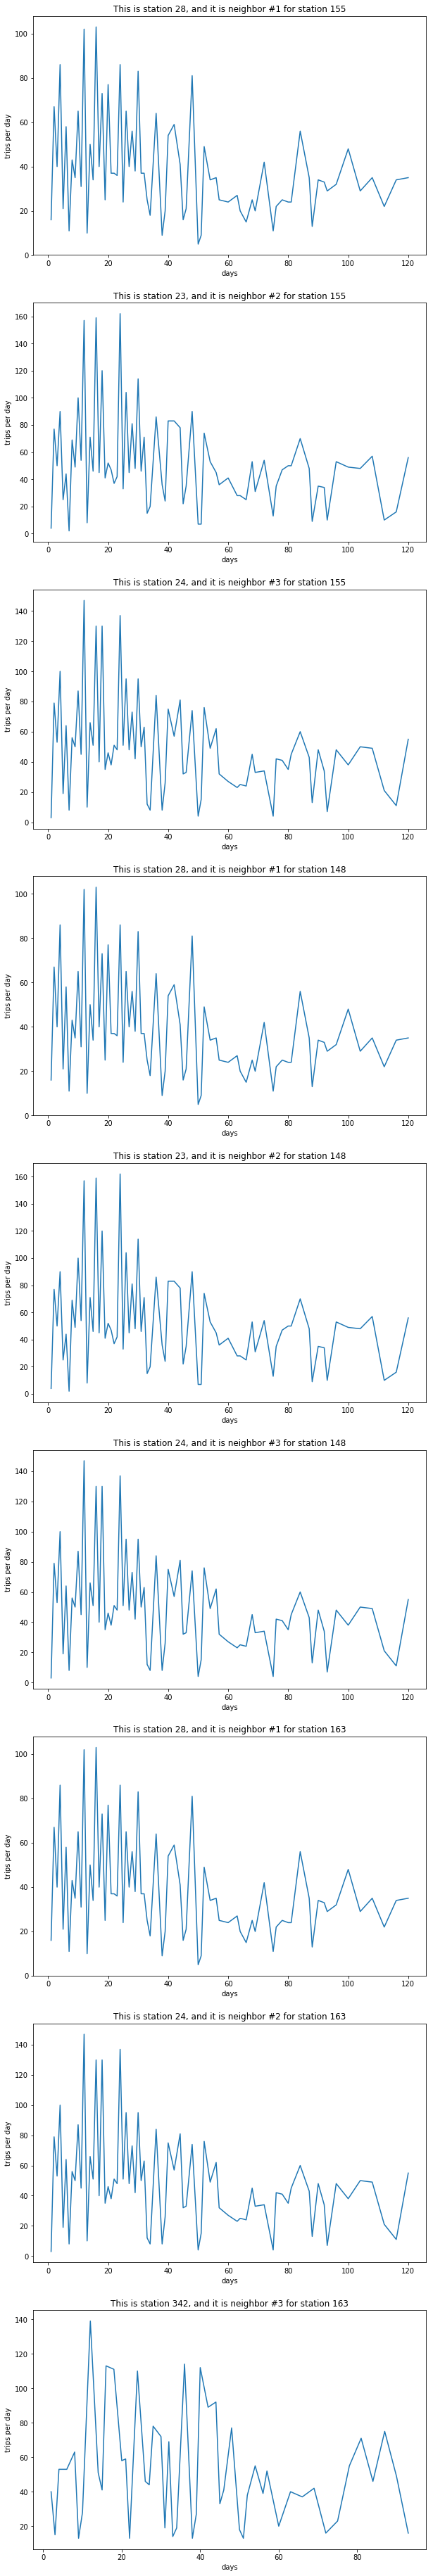

In [122]:
plt_stn()

In [100]:
ts = days_count(qtr, 4)

In [101]:
tseries = pd.Series(ts[:,1])

In [102]:
test = sm.tsa.stattools.adfuller(tseries)
print("ADF p-value: {0:2.2f}".format(test[1]))

ADF p-value: 0.48


In [103]:
tseries_diffed = tseries.diff()[1:]

In [104]:
sm.tsa.stattools.adfuller(tseries_diffed)[1]

9.366704990120353e-05

In [105]:
sm.tsa.stattools.adfuller(tseries_diffed)[1]>0.05

False

In [106]:
def stationary_convert(series, pvalue=0.05):
    test = sm.tsa.stattools.adfuller(series)
    if test[1] > pvalue:
        tseries_diffed = tseries.diff()[1:]
        return tseries_diffed
    return series

In [107]:
trip_matrix = tseries.as_matrix()
trip_matrix

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([10, 25, 19, 37, 11, 23,  6, 36, 16, 20, 12, 65, 17, 27, 20, 47, 17,
       22, 10, 32, 30, 19, 16, 52, 18, 36, 31, 31, 15, 43, 18, 27, 13, 15,
       38,  7, 11, 28, 25, 19, 10, 13, 33, 11,  9, 26, 20, 17,  8, 20, 12,
        5, 13,  8, 15, 31,  6, 16, 17, 15, 21, 37, 14, 10, 18,  8, 14, 18,
       17, 23, 13, 22, 10, 26])

In [108]:
trip_model = ARIMA(trip_matrix, order=(3, 1, 0)).fit()

In [109]:
predictions = trip_model.predict(75, 85, typ='levels')
predictions

array([13.72412107, 20.13992321, 14.22524071, 22.02764457, 14.8518136 ,
       19.19415794, 15.93260204, 19.72899561, 15.77597194, 18.51574932,
       16.56760325, 18.45952311])

In [110]:
test = np.append(trip_matrix, predictions)

In [111]:
test1 = pd.Series(test)

In [112]:
test1

0     10.000000
1     25.000000
2     19.000000
3     37.000000
4     11.000000
5     23.000000
6      6.000000
7     36.000000
8     16.000000
9     20.000000
10    12.000000
11    65.000000
12    17.000000
13    27.000000
14    20.000000
15    47.000000
16    17.000000
17    22.000000
18    10.000000
19    32.000000
20    30.000000
21    19.000000
22    16.000000
23    52.000000
24    18.000000
25    36.000000
26    31.000000
27    31.000000
28    15.000000
29    43.000000
        ...    
56     6.000000
57    16.000000
58    17.000000
59    15.000000
60    21.000000
61    37.000000
62    14.000000
63    10.000000
64    18.000000
65     8.000000
66    14.000000
67    18.000000
68    17.000000
69    23.000000
70    13.000000
71    22.000000
72    10.000000
73    26.000000
74    13.724121
75    20.139923
76    14.225241
77    22.027645
78    14.851814
79    19.194158
80    15.932602
81    19.728996
82    15.775972
83    18.515749
84    16.567603
85    18.459523
Length: 86, dtype: float

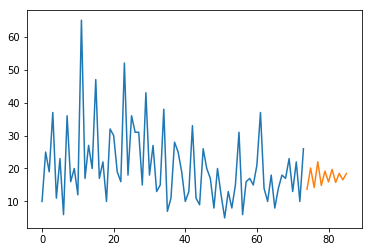

In [113]:
plt.plot(test1.index[0:74], test1[0:74])
plt.plot(test1.index[74:], test1[74:])


In [114]:
from sklearn.model_selection import TimeSeriesSplit

Observations: 38
Training Observations: 20
Testing Observations: 18
Observations: 56
Training Observations: 38
Testing Observations: 18
Observations: 74
Training Observations: 56
Testing Observations: 18


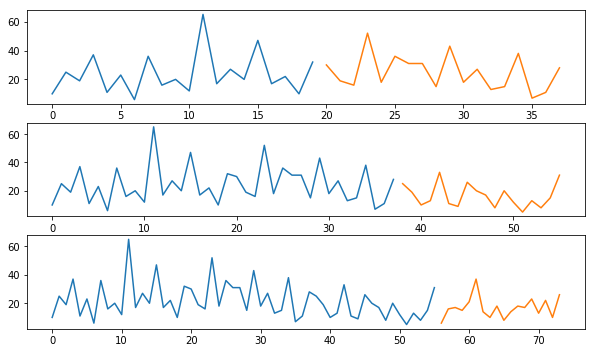

In [115]:
tseries = pd.Series(ts[:,1])
tscv = TimeSeriesSplit(n_splits=3)
fig = plt.figure(figsize=(10,10))
index = 1
for train_index, test_index in tscv.split(tseries):
    train = tseries[train_index]
    test = tseries[test_index]

    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    plt.subplot(5,1,index)
    plt.plot(train)
    plt.plot([None for i in train] + [x for x in test])
    index += 1
plt.show()

In [116]:
def ARIMA_pred(arr, p=3, d=1, q=0):
    tseries = pd.Series(arr[:,1])
    
    tscv = TimeSeriesSplit(n_splits=3)
    fig = plt.figure(figsize=(10,10))
    index = 1
    
    actual = []
    
    for train_index, test_index in tscv.split(tseries):
        train = tseries[train_index]
        test = tseries[test_index]

        train_matrix = train.as_matrix()
        a_model = ARIMA(train_matrix, order=(p, d, q)).fit()
    
        train_sze = len(train)
        predictions = trip_model.predict(train_sze, train_sze+len(test)-1, typ='levels')
        
        #calculate mean squared error
        mse = mean_squared_error(predictions, np.array(test))
        
        #combine to plot on same graph
        combined = np.append(trip_matrix, predictions)
        combined = pd.Series(combined)
        plt.subplot(3,1,index)
        plt.xlabel('Days')
        plt.ylabel('Trip Counts')
        plt.title('This has a mean squared error of {}'.format(mse))
        plt.plot(combined.index[:train_sze], combined[:train_sze])
        plt.plot(combined.index[train_sze:], combined[train_sze:])
#         plt.plot(test)
        print (np.array(test))
#         print(len(train_index))
#         print (test_index)
        print (predictions)
        
        index +=1
        



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


[30 19 16 52 18 36 31 31 15 43 18 27 13 15 38  7 11 28]
[15.66635879 20.56033277 19.54287858 29.29671767 22.54200235 25.63839382
 24.41562546 40.65541537 24.68608253 34.634785   26.50311165 30.20419075
 22.04569254 34.49813729 19.19818175 19.86281937 19.39669625 19.18226091]
[25 19 10 13 33 11  9 26 20 17  8 20 12  5 13  8 15 31]
[24.28598738 11.60779368 17.94633832 26.06559861 20.57803882 14.34319619
 15.79265358 17.77467275 22.11459895 13.21813093 15.263468   23.2922698
 16.33725728 15.49535989 12.02012152 14.77207767 10.49758382  7.00633061]
[ 6 16 17 15 21 37 14 10 18  8 14 18 17 23 13 22 10 26]
[10.9629619  14.99800382 16.85979498 21.79645317 10.40095239 15.58181158
 16.07537414 21.45452239 24.01202253 25.87093303 14.06994639 11.21670375
 14.35381092 11.14222388 15.03330726 19.01281692 17.18782261 20.79174364]


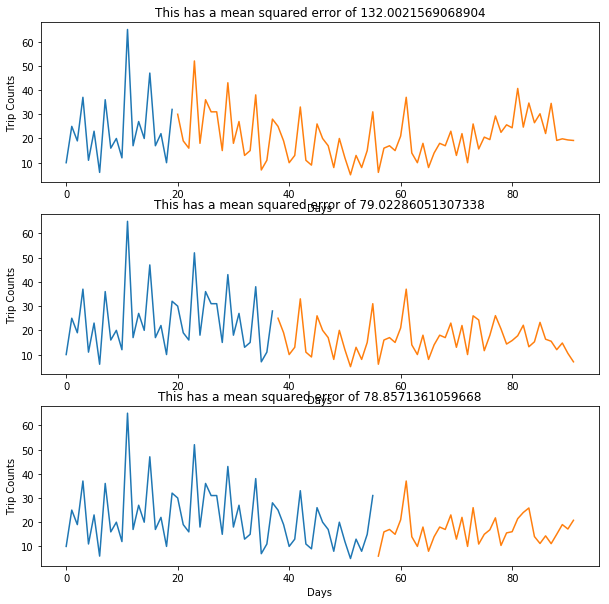

In [117]:
ARIMA_pred(ts,3,1,0)

In [118]:
# #Print MSE to see how good the model is
# Error = mean_squared_error(TestData, Predictions)
# print('Test Mean Squared Error (smaller the better fit): %.3f' % Error)
# # plot
# pyplot.plot(TestData)
# pyplot.plot(Predictions, color='red')
# pyplot.show()

In [119]:
# #in a for loop, predict values using ARIMA model
# for timepoint in range(len(TestData)):
#     ActualValue =  TestData[timepoint]
#     #forcast value
#     Prediction = StartARIMAForecasting(Actual, 3,1,0)    
#     print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
#     Predictions.append(Prediction)
#     Actual.append(ActualValue)